<a href="https://colab.research.google.com/github/GiuliaLanzillotta/exercises/blob/master/Cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Some fun with Convolutional Neural Networks
--- 
This code is partly taken from @ETHZ **Machine perception** class 
```
# What you need for this notebook:
# Python 3 
# Tensorflow 1.x : we will build a CNN with the 1.x APIs 
# (I know, this sounds suicidal now, but it's still a good exercise)

```






> ### But what is a convolution? 
A convolution is a mathematical operation used in image processing tasks. It takes as input a signal (not necessarly an image) and a kernel or filter, and it applies the filter to the original signal, producing a *filtered* signal. 

Depending on what filter you use to convolve an image with, you can use convolutions to blur an image (i.e., removing high-frequency noise), detect edges, and many other cool operations. 






> ### And what does it have to do with recognising cats? 
In the context of CNN convolution is not used to produced a desired effect on an image. We build a neural network architecture with a specific task  in mind (e.g. recognising what is in the picture) and we let the neural network learn the best *sequence of convolution filters* to accomplish the task easily. 


Enough with the talking, **let's code**!





## Gathering the data

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False # we don't like the warnings

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
import os

# Tensorboard in Colab environment.
!pip install tensorboardcolab
from tensorboardcolab import *
tbc = TensorBoardColab()

Using TensorFlow backend.


Wait for 8 seconds...
TensorBoard link:
https://596341e1.ngrok.io


In [0]:
# This is the dataset we are using
from tensorflow.examples.tutorials.mnist import input_data

In [5]:
# Import the data
log_dir = "/tmp/tensorflow/mnist_cnn/logs"
mnist = input_data.read_data_sets(log_dir, one_hot=False, fake_data=False)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/tensorflow/mnist_cnn/logs/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/tensorflow/mnist_cnn/logs/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/tensorflow/mnist_cnn/logs/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/tensorflow/mnist_cnn/logs/t10k-labels-idx1-ubyte.gz


In [0]:
features_dict = {
    "image_shape" : (28,28), 
    "num_image_channels" : 1 ,
    "num_classes": 10
}
image_size_flat = features_dict["image_shape"][0]*features_dict["image_shape"][1]\
*features_dict["num_image_channels"]

In [0]:
# Helper function to plot the images 
def plot_9_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true)==9
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    for i,ax in enumerate(axes.flat):
      ax.imshow(images[i].reshape(features_dict["image_shape"]), cmap='binary')
      # Show true and predicted classes.
      if cls_pred is None:
          xlabel = "True: {0}".format(cls_true[i])
      else:
          xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
      ax.set_xlabel(xlabel)
      # Remove ticks 
      ax.set_xticks([])
      ax.set_yticks([])

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


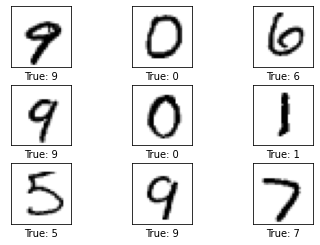

In [8]:
# Print some stats
print("Size of:")
print("- Training-set:\t\t{}".format(len(mnist.train.labels)))
print("- Test-set:\t\t{}".format(len(mnist.test.labels)))
print("- Validation-set:\t{}".format(len(mnist.validation.labels)))
# Plot some images from the test set
plot_9_images(images= mnist.test.images[9:18], cls_true= mnist.test.labels[9:18])

## Building the model

#### Hyperparameters 

In [0]:
# Setting the hyperparameters through FLAGS
# Helper function to reset the flags
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

# reset all 
del_all_flags(tf.flags.FLAGS)

# define the new ones
tf.app.flags.DEFINE_string("log_dir", log_dir, "Summaries log directory")
tf.app.flags.DEFINE_string("feature_map_sizes", "32,64,128", "Number of layers to be used and number of feature maps per layer")
tf.app.flags.DEFINE_string("filter_sizes", "5,5,5", "Size of square filters per layer")
tf.app.flags.DEFINE_string("strides", "1,1,1", "Size of the stride in each convolution")
tf.app.flags.DEFINE_float("learning_rate", 1e-3, "Learning rate (default: 1e-3)")
tf.app.flags.DEFINE_integer("batch_size", 128, "Batch size (default: 128)")
tf.app.flags.DEFINE_integer("max_steps", 10000, "Number training steps/iterations (default: 1000)")
tf.app.flags.DEFINE_integer("evaluate_every_step", 250, "Evaluate model on validation set after this many steps/iterations (i.e., batches) (default: 50)")
tf.app.flags.DEFINE_string('f', '', 'kernel')  # Dummy entry so that colab doesn't complain.

In [10]:
# Now let's check we have correctly set the flags
FLAGS = tf.app.flags.FLAGS
print("FLAGS:")
for key in FLAGS.flag_values_dict():
  print("{:<22}: {}".format(key.upper(), FLAGS[key].value))
print("")

FLAGS:
LOG_DIR               : /tmp/tensorflow/mnist_cnn/logs
FEATURE_MAP_SIZES     : 32,64,128
FILTER_SIZES          : 5,5,5
STRIDES               : 1,1,1
LEARNING_RATE         : 0.001
BATCH_SIZE            : 128
MAX_STEPS             : 10000
EVALUATE_EVERY_STEP   : 250
F                     : 



#### Variables (or parameters)

In [0]:
# Now we create some helper functions to create the variables of the model (the trainable parameters)
def new_weight(shape):
  return tf.Variable(tf.contrib.layers.xavier_initializer(uniform=False)(shape=shape))
def new_bias(shape):
  return tf.Variable(tf.constant(0.1, shape=shape))

# helper function to compute summary statistics for each variable
def get_summary(var):
  mean = tf.reduce_mean(var)
  tf.summary.scalar("mean",mean)
  tf.summary.scalar('max', tf.reduce_max(var))
  tf.summary.scalar('min', tf.reduce_min(var))
  with tf.name_scope('stddev'):
    stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
  tf.summary.scalar('stddev', stddev)
  tf.summary.histogram('histogram', var)

#### Layers (the nodes in our computational graph)

In [0]:
# Now what is left is to draw the computational graph, inserting some nodes first
# and some edges later

In [0]:
# Helper functions to create layers 

# 1. FULLY CONNECTED
def dense(input,output_dim,layer_name,activation=tf.nn.relu):
  with tf.name_scope(layer_name): # example '/layer'
    input_dim = input.get_shape()[-1].value
    with tf.name_scope('weights'): ## '/layer/weights'
      weights = new_weight([input_dim, output_dim])
      get_summary(weights)
    with tf.name_scope('biases'): ## '/layer/biases'
      biases = new_bias([output_dim])
      get_summary(biases)
    with tf.name_scope('affine_op'): ## 'layer/affine_op'
      affine = tf.matmul(input, weights) + biases
      tf.summary.histogram('affine', affine)
    activations = activation(affine, name='activation') ## 'layer/activation'
    tf.summary.histogram('activations', activations)
    return activations, weights

# 2. CONVOLUTION 
# Defaults: 
# - square filters 
# - symmetric strides [1, s, s, 1]
# - max pooling with kernel 2x2, strides 2x2 ans SAME padding
def convl_square(input, filter_size, num_filters, layer_name, 
            pooling = True, strides=1, activation = tf.nn.relu, 
            padding = "SAME"):
  # Note: padding should be either "SAME" or "VALID"
  with tf.name_scope(layer_name):
    # Initialise 
    num_input_channels = input.get_shape()[-1].value
    kernel_shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weight(shape=kernel_shape)
    biases = new_bias(shape=[num_filters])
    # Convolutional layer
    layer = tf.nn.conv2d(input=input,filter=weights, 
                         strides=[1, strides, strides, 1],padding=padding)
    layer += biases
    # Pooling layer 
    if pooling:
      layer = tf.nn.max_pool(value=layer,ksize=[1, 2, 2, 1], 
                             strides=[1, 2, 2, 1], padding='SAME')
    # Activation 
    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.
    layer = activation(layer)

    return layer, weights

# 3. FLATTEN 
# Flattening the 4-dimensional tensor (output of the convolution)
# into 2 dimensions (expected input to a fully connected)
def flatten(input):
  # layer_shape == [num_images, img_height, img_width, num_channels]
  layer_shape = input.get_shape()
  # The 4 dimensions will be flattened into [num_samples, num_features]
  num_features = layer_shape[1:4].num_elements()
  layer_flat = tf.reshape(input, [-1, num_features])
  return layer_flat, num_features

## Trainin the model

In [0]:
# First of all, placeholders! 
with tf.name_scope('input'):
  images_flat = tf.placeholder(tf.float32, [None, image_size_flat], name='x-input')
  data_placeholder = tf.reshape(images_flat, [-1, features_dict["image_shape"][0], 
                                              features_dict["image_shape"][1], 
                                              features_dict["num_image_channels"]])
  label_placeholder = tf.placeholder(tf.int32, [None], name='y-input')

In [0]:
# Then , hyperparameters
feature_map_sizes = list(map(int, FLAGS.feature_map_sizes.split(',')))
filter_sizes = list(map(int, FLAGS.filter_sizes.split(',')))
strides = list(map(int, FLAGS.strides.split(',')))
assert len(filter_sizes) == len(feature_map_sizes) == len(strides)

In [16]:
# Now, assemble the model!
next_in = data_placeholder
weights = []
layer_outs = []
# SERIE OF CONVOLUTIONS
for i, (num_out_channels, filter_size, stride) in \
enumerate(zip(feature_map_sizes, filter_sizes, strides)):
    next_in, w = convl_square(next_in, filter_size, num_out_channels,
                              'conv{}_layer'.format(i), pooling=True,strides=stride)
    weights.append(w)
    layer_outs.append(next_in)
# FLATTENING 
out_flat, _ = flatten(next_in)
# FULLY CONNECTED HEAD
logits, _ = dense(out_flat, features_dict["num_classes"], 
                        'dense_layer', activation=tf.identity)
probs = tf.nn.softmax(logits)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
# Loss function: Cross-Entropy
# the cross entropy function is implicitly measuring the KL-divergence
# between the data distribution and the model output distribution
with tf.name_scope('cross_entropy'):
    cross_entropy_loss = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=label_placeholder))
    tf.summary.scalar('cross_entropy_loss', cross_entropy_loss)

In [18]:
# Helper function to check the number of trainable parameters
def count_trainable_parameters():
    """Counts the number of trainable parameters in the current default graph."""
    tot_count = 0
    for v in tf.trainable_variables():
        v_count = 1
        for d in v.get_shape():
            v_count *= d.value
        tot_count += v_count
    return tot_count
print("Number of trainable parameters: {}".format(count_trainable_parameters()))

Number of trainable parameters: 277514


In [0]:
# Now the optimizer ! 
# We use SGD 
global_step = tf.Variable(1, name='global_step', trainable=False)
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(FLAGS.learning_rate).minimize(
        cross_entropy_loss, global_step=global_step)    
with tf.name_scope('accuracy'):
    with tf.name_scope('correct_predictions'):
        correct_predictions = tf.nn.in_top_k(logits, label_placeholder, 1)
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    tf.summary.scalar('accuracy', accuracy)

In [20]:
# Finally we create the session and initialize the variables 
sess = tf.InteractiveSession()

train_writer = tbc.get_deep_writers("single_layer_model/train")
train_writer.add_graph(sess.graph)
valid_writer = tbc.get_deep_writers("single_layer_model/valid")
valid_writer.add_graph(sess.graph)

sess.run(tf.global_variables_initializer())

summaries_merged = tf.summary.merge_all()

In [0]:
# Helper function to manage the input 
def feed_dict(train_mode):
    if train_mode:
        xs, ys = mnist.train.next_batch(FLAGS.batch_size)
    else:
        xs, ys = mnist.validation.images, mnist.validation.labels
    return {images_flat:xs, label_placeholder:ys}

# TRAINING LOOP
def do_train_step(num_steps, summary_op):
    for i in range(num_steps):
        step = tf.train.global_step(sess, global_step)
        if step % FLAGS.evaluate_every_step == 0:
            summary, acc_valid = sess.run([summary_op, accuracy], feed_dict=feed_dict(False))
            valid_writer.add_summary(summary, step)
            print('[{}] Accuracy Training [{:.3f}], Validation [{:.3f}]'.format(step, acc_valid, acc_train)) 

        summary, acc_train, _ = sess.run([summary_op, accuracy, train_step], feed_dict=feed_dict(True))
        train_writer.add_summary(summary, step)

In [22]:
do_train_step(10000, summaries_merged)

[250] Accuracy Training [0.272], Validation [0.281]
[500] Accuracy Training [0.559], Validation [0.555]
[750] Accuracy Training [0.585], Validation [0.578]
[1000] Accuracy Training [0.648], Validation [0.633]
[1250] Accuracy Training [0.703], Validation [0.664]
[1500] Accuracy Training [0.750], Validation [0.727]
[1750] Accuracy Training [0.785], Validation [0.805]
[2000] Accuracy Training [0.802], Validation [0.852]
[2250] Accuracy Training [0.834], Validation [0.805]
[2500] Accuracy Training [0.851], Validation [0.875]
[2750] Accuracy Training [0.872], Validation [0.805]
[3000] Accuracy Training [0.879], Validation [0.859]
[3250] Accuracy Training [0.888], Validation [0.898]
[3500] Accuracy Training [0.900], Validation [0.852]
[3750] Accuracy Training [0.902], Validation [0.930]
[4000] Accuracy Training [0.905], Validation [0.922]
[4250] Accuracy Training [0.913], Validation [0.922]
[4500] Accuracy Training [0.915], Validation [0.930]
[4750] Accuracy Training [0.919], Validation [0.8

In [0]:
# Now it's time to test
test_images = mnist.test.images[0:9]
test_cls_true = mnist.test.labels[0:9]
feed_dict = {images_flat: test_images}
logits_np = sess.run(logits, feed_dict)

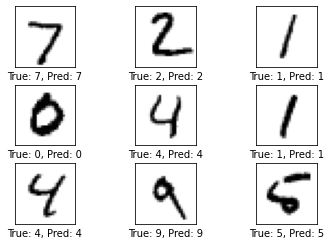

In [24]:
test_cls_predicted = np.argmax(logits_np, axis=-1)
plot_9_images(test_images, test_cls_true, test_cls_predicted)